In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [120]:
df = pd.read_csv("../data/factor_tax.csv", index_col=[0, 1], header=[0, 1]).fillna(0)
np.testing.assert_allclose(df.sum(axis=0).values, df.sum(axis=1).values)

In [238]:
variables = [
    Variable(name="Y", description="Output", positive=True),
    Variable(name="C", description="Consumption", positive=True),
    Variable(name="I", description="Investment", positive=True),
    Variable(name="income", description="Household income", latex_name="Omega", positive=True),
    Variable(
        name="net_income", description="Household after-tax income", latex_name="\\hat{\\Omega}"
    ),
    Variable(name="L_d", description="Firm demand for labor", positive=True),
    Variable(name="K_d", description="Firm demand for capital", positive=True),
    Variable(name="C_G", description="Government consumption"),
    Variable(name="r", description="Rental rate of capital", positive=True),
    Variable(name="r_star", description="After-tax rental rate", positive=True),
    Variable(name="w_star", description="After-tax wage level", positive=True),
    Variable(name="P_Y", description="Producer price level", positive=True),
    Variable(name="P", description="Price level", positive=True),
    Variable(name="resid", latex_name="varepsilon", description="Walrasian residual"),
]

parameters = [
    Parameter(name="I_d", description="Firm demand for investment capital", positive=True),
    Parameter(name="L_s", description="Household labor supply"),
    Parameter(name="K_s", description="Household capital supply"),
    Parameter(name="I_G", description="Government investment"),
    Parameter(name="tau_income", latex_name="\\tau_Y", description="Income tax rate"),
    Parameter(name="tau_sales", latex_name="\\tau_P", description="Sales tax rate"),
    Parameter(name="tau_capital", latex_name="\\tau_r", description="Capital income tax"),
    Parameter(name="tau_wage", latex_name="\\tau_w", description="Payroll tax"),
    Parameter(name="A", description="Total factor productivity"),
    Parameter(name="epsilon", description="Elasticity of substitution between capital and labor"),
    Parameter(name="alpha", description="Share of capital in production"),
    Parameter(name="w", description="Wage level", positive=True),
]

equations = [
    # Firm equations
    Equation(
        name="Production function",
        equation="Y = A * (alpha * K_d ** ((epsilon - 1) / epsilon) +"
        "(1 - alpha) * L_d ** ((epsilon - 1) / epsilon)) ** (epsilon / (epsilon - 1))",
    ),
    Equation(name="Capital demand", equation="K_d = Y / A * (alpha * A * P_Y / r_star) ** epsilon"),
    Equation(
        name="Labor demand", equation="L_d = Y / A * ((1 - alpha) * A * P_Y / w_star) ** epsilon"
    ),
    # Household equations
    Equation(name="Household income", equation="income = w * L_s + r * K_s"),
    Equation(name="Net household income", equation="net_income = (1 - tau_income) * income"),
    Equation(name="Household budget constraint", equation="P * (C + I) = net_income"),
    # Government equations
    Equation(name="Price level", equation="P = (1 + tau_sales) * P_Y"),
    Equation(name="Net rental rate", equation="r_star = (1 + tau_capital) * r"),
    Equation(name="Net wage level", equation="w_star = (1 + tau_wage) * w"),
    Equation(
        name="Government budget constraint",
        equation="P * (C_G + I_G) = tau_income * income + tau_sales * P_Y  * Y"
        "+ tau_capital * r * K_s + tau_wage * w * L_s",
    ),
    # Equlibrium conditions
    Equation(name="Economic resource constraint", equation="Y = C + I + I_G + C_G"),
    Equation(name="Labor market clearing", equation="L_s = L_d"),
    Equation(name="Capital market clearing", equation="K_s = K_d"),
    Equation(name="Investment market clearing", equation="I_d = I + I_G + resid"),
]

In [240]:
mod = CGEModel(
    variables=variables,
    parameters=parameters,
    equations=equations,
    parse_equations_to_sympy=True,
    backend="pytensor",
    mode="JAX",
    compile=True,
)

n_eq = len(mod.unpacked_equation_names)
n_var = mod.n_variables
assert n_eq == n_var, f"{n_eq} equations, {n_var} variables"

In [243]:
def calibrate_model(
    *,
    sales_tax_revenue,
    income_tax_revenue,
    capital_tax_revenue,
    wage_tax_revenue,
    Y,
    K_s,
    L_s,
    C,
    I,
    C_G,
    I_G,
    K_d,
    L_d,
    epsilon,
    mod
):
    from copy import deepcopy

    rho = (epsilon - 1) / epsilon

    w = 1.0
    resid = 0.0
    r = 1.0
    P_Y = 1.0

    tau_sales = sales_tax_revenue / (Y - sales_tax_revenue)
    tau_capital = capital_tax_revenue / (K_d - capital_tax_revenue)
    tau_wage = wage_tax_revenue / (L_d - wage_tax_revenue)

    P = P_Y * (1 + tau_sales)
    r_star = r * (1 + tau_capital)
    w_star = w * (1 + tau_wage)

    K_d /= r_star
    L_d /= w_star

    Y /= P
    C /= P
    I /= P
    C_G /= P
    I_G /= P

    alpha = (
        r_star
        * K_d ** (1 / epsilon)
        / ((r_star * K_d ** (1 / epsilon) + w_star * L_d ** (1 / epsilon)))
    )
    A = Y * (alpha * K_d**rho + (1 - alpha) * L_d**rho) ** (-1 / rho)

    income = r * K_s + w * L_s
    tau_income = income_tax_revenue / income
    net_income = (1 - tau_income) * income

    I_d = I + I_G + resid

    d = {}
    for obj in mod.variables + mod.parameters:
        d[obj.name] = deepcopy(locals()[obj.name])

    return d

In [244]:
initial_data = {
    "Y": df.loc[("Production")].values.sum(),
    "K_s": df.loc[("Institution", "Household"), ("Factor", "Capital")],
    "L_s": df.loc[("Institution", "Household"), ("Factor", "Labor")],
    "K_d": df.loc[("Factor", "Capital"), :].sum(),
    "L_d": df.loc[("Factor", "Labor"), :].sum(),
    "C": df.loc[("Production", "Firm"), ("Institution", "Household")],
    "I": df.loc[("Other", "Investment"), ("Institution", "Household")],
    "C_G": df.loc[("Production", "Firm"), ("Institution", "Govt")],
    "I_G": df.loc[("Other", "Investment"), ("Institution", "Govt")],
    "sales_tax_revenue": df.loc[("Institution", "Govt"), ("Production", "Firm")],
    "income_tax_revenue": df.loc[("Institution", "Govt"), ("Institution", "Household")],
    "capital_tax_revenue": df.loc[("Institution", "Govt"), ("Factor", "Capital")],
    "wage_tax_revenue": df.loc[("Institution", "Govt"), ("Factor", "Labor")],
}

econometric_estimates = {"epsilon": 3.0}

calibrated_data = calibrate_model(mod=mod, **(initial_data | econometric_estimates))

In [245]:
mod.check_for_equilibrium(calibrated_data)

Equilibrium found! Total squared error: 0.000000


In [250]:
np.linalg.inv(mod.f_jac(**calibrated_data));

In [248]:
idata_sim = mod.simulate(
    initial_state=calibrated_data,
    final_delta_pct={"L_s": 0.25},
    use_euler_approximation=True,
    optimizer_mode="minimize",
    method="trust-ncg",
)

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=5.03879e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=2.00941e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.24805e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=2.83196e-27): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packag

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.63501e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=2.22878e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=6.44886e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.45274e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packag

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=8.68294e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=3.5084e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=2.15143e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.04574e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-package

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=8.90897e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.90252e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.11826e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=9.26807e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packag

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=2.23853e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.11302e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.75887e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.1384e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-package

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=7.865e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=5.41559e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=2.15434e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.75645e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.76422e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.66617e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.45549e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=5.67422e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packag

/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.33742e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=7.16239e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=8.66844e-26): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/pytensor/tensor/slinalg.py:382: LinAlgWarning: Ill-conditioned matrix (rcond=1.92144e-25): result may not be accurate.
  outputs[0][0] = scipy.linalg.solve(
/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packag

LinAlgError: Matrix is singular.
Apply node that caused the error: Solve{assume_a='gen', lower=False, check_finite=False, b_ndim=2}(SpecifyShape.0, [[1. 0. 0. ... 0. 0. 1.]])
Toposort index: 81
Inputs types: [TensorType(float64, shape=(14, 14)), TensorType(float64, shape=(14, 14))]
Inputs shapes: [(14, 14), (14, 14)]
Inputs strides: [(112, 8), (112, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Neg(A_inv)]]

Backtrace when the node is created (use PyTensor flag traceback__limit=N to make it longer):
  File "/Users/jessegrabowski/mambaforge/envs/cge-dev/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/7b/rzxy96cj0w751_6td3g2yss00000gn/T/ipykernel_94768/3645539894.py", line 1, in <module>
    idata_sim = mod.simulate(initial_state=calibrated_data,
  File "/Users/jessegrabowski/Documents/Python/OECD/cge_modeling/notebooks/Tests and Ohter/../../cge_modeling/base/cge.py", line 1102, in simulate
    idata_euler = self._solve_with_euler_approximation(
  File "/Users/jessegrabowski/Documents/Python/OECD/cge_modeling/notebooks/Tests and Ohter/../../cge_modeling/base/cge.py", line 777, in _solve_with_euler_approximation
    result = self.f_euler(**data, theta_final=theta_final, n_steps=n_steps)
  File "/Users/jessegrabowski/Documents/Python/OECD/cge_modeling/notebooks/Tests and Ohter/../../cge_modeling/base/cge.py", line 608, in __pytensor_euler_helper
    self.__compiled_f_euler = euler_approximation_from_CGEModel(self, n_steps=n_steps)
  File "/Users/jessegrabowski/Documents/Python/OECD/cge_modeling/notebooks/Tests and Ohter/../../cge_modeling/pytensorf/compile.py", line 313, in euler_approximation_from_CGEModel
    return compile_euler_approximation_function(
  File "/Users/jessegrabowski/Documents/Python/OECD/cge_modeling/notebooks/Tests and Ohter/../../cge_modeling/pytensorf/compile.py", line 303, in compile_euler_approximation_function
    theta_final, result = euler_approximation(equations, variables, parameters, n_steps=n_steps)
  File "/Users/jessegrabowski/Documents/Python/OECD/cge_modeling/notebooks/Tests and Ohter/../../cge_modeling/pytensorf/compile.py", line 254, in euler_approximation
    A_inv = pt.linalg.solve(A, pt.identity_like(A), check_finite=False)

HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.
Apply node that caused the error: Scan{scan_fn, while_loop=False, inplace=all}(10000, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, SetSubtensor{:stop}.0, Composite{(0.0001 * (i0 - i1))}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0, Reshape{0}.0)
Toposort index: 180
Inputs types: [TensorType(int16, shape=()), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(10000,)), TensorType(float64, shape=(12,)), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=())]
Inputs shapes: [(), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (10000,), (12,), (), (), (), (), (), (), (), (), (), (), (), ()]
Inputs strides: [(), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (8,), (), (), (), (), (), (), (), (), (), (), (), ()]
Inputs values: [array(10000, dtype=int16), 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', array(0.), array(-0.15), array(0.), array(0.), array(0.), array(0.), array(0.), array(0.), array(0.), array(0.), array(0.), array(0.)]
Outputs clients: [[Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.0)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.1)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.2)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.3)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.4)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.5)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.6)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.7)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.8)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.9)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.10)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.11)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.12)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.13)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.14)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.15)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.16)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.17)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.18)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.19)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.20)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.21)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.22)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.23)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.24)], [Join(0, ExpandDims{axis=0}.0, Scan{scan_fn, while_loop=False, inplace=all}.25)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

Matrix is singular --> Jacobian isn't full rank. We should have some eigenvalues close to zero

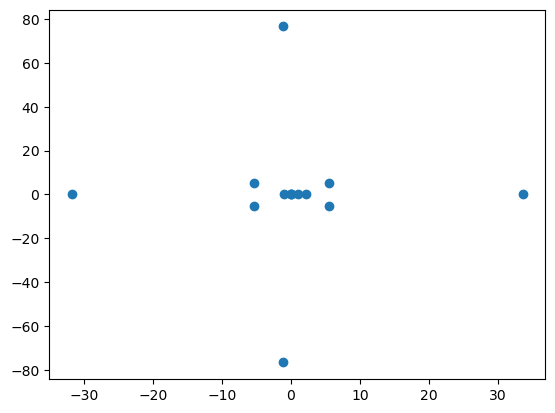

In [255]:
jac = mod.f_jac(**calibrated_data)
jac_eigs = np.linalg.eigvals(jac)
fig, ax = plt.subplots()
ax.scatter(jac_eigs.real, jac_eigs.imag)
plt.show()

In [257]:
np.linalg.cond(jac)

2.102113076848679e+20

In [258]:
np.linalg.matrix_rank(jac)

13

In [259]:
jac.shape

(14, 14)